<a href="https://colab.research.google.com/github/charliashby/05/blob/main/Ashby_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Q1

In [2]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


To preprocess the data, I removed "stop words," including punctuation, extremely common words like "and" and "the," as well as numbers. Next, I applied one-hot encoding to the tokens, transforming them into features (or covariates/predictors) for each email. Using these features, I ran algorithms to predict whether the emails were scams based on the presence of specific tokens. While there are many approaches to tackle this task, I concentrated on PCA and linear models, as these were the primary focus of the assignment.



#Q2

Saving all_tokens.pickle to all_tokens (2).pickle


<Axes: >

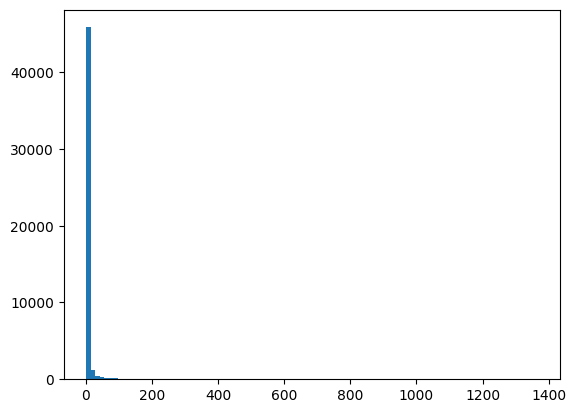

In [9]:
from google.colab import files
uploaded = files.upload()

with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

In [10]:
gdf['count'].describe()

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


The token frequency distribution has a very long tail: most tokens appear only once, and just a small number occur more than 10 times. Even at the 75th percentile, tokens appear only twice, while the most frequent token appears 1,365 times. This creates some challenges: tokens that appear only a few times are unlikely to be useful for predicting scams, while highly frequent words, such as "the" or "and," which appear in nearly every email, are also not very predictive.

#Q3

In [13]:
from google.colab import files
uploaded = files.upload()

df = pd.read_parquet('Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)

## 1.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

## 2.
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

Saving Phishing_clean.parquet to Phishing_clean (1).parquet
train:  0.6210107280960204
test:  -0.00026838432670373


In [14]:

rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


The most frequent variables, unfortunately, turn out to be just numbers. I was hoping the scams would stand out more clearly, but this does highlight the advantage of using the PCA approach.

The model performs reasonably well on the training set, achieving a score of 0.62. However, its performance on the test set is barely better than predicting the mean. This suggests the model is overfitting, which isn’t surprising given the 2,611 features that are likely highly correlated.

#Q4

<Axes: >

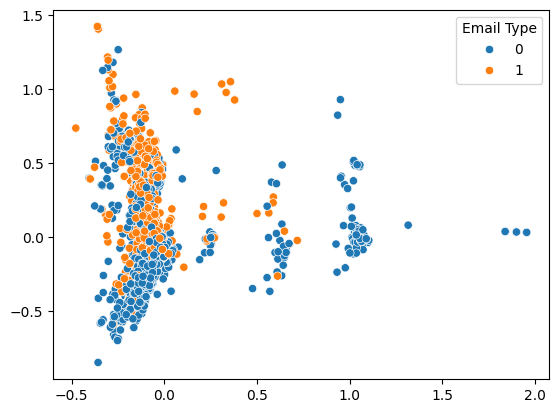

In [15]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The orange dots represent the scam emails. They typically have a high value on the second component and a low value on the first component. The goal of our model is to effectively separate these orange dots from the blue dots.

#Q5

In [16]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


This is much better performance than the vanilla linear regression: 0.587
 rather than basically 0 for the simple linear model, and much closer to the training
 of 0.692.

#Q6

Since the features (or covariates) are made independent and orthogonal through PCA decomposition, multicollinearity is no longer an issue. Additionally, it’s simpler to choose how many components to include—1, 2, ..., up to 2,711—rather than deciding between various possible combinations of features. However, while individual words are interpretable, the components themselves lack clear interpretability.